In [15]:
include("Interpolation.jl")

my_lin_interp (generic function with 1 method)

In [51]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
                
                
                

#using Interpolations#ここを書き換え
using Optim
using Plots
pyplot()             
"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    bet::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end


default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, bet=0.95, u=default_u, grid_max=2,
                     grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, bet, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector;
                           ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw = my_lin_interp(g.grid, w)

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.bet * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector;
                          ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)

                
                
function main(n::Int=35)
    gm = GrowthModel()
    w_init = 5 .* log(gm.grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    bet = gm.bet
    alpha = 0.65
    ## Exact solution
    ab = alpha * bet
    c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
    c2 = alpha / (1 - ab)
    v_star(k) = c1 .+ c2 .* log(k)                
                    
    for i=1:n
        w = bellman_operator(gm, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end
   
    p = plot(gm.grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(gm.grid, ws, color=colors', label="", linewidth=2)
    plot!(gm.grid, v_star(gm.grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(gm.grid), maximum(gm.grid)))

    
    return p
end

main (generic function with 2 methods)


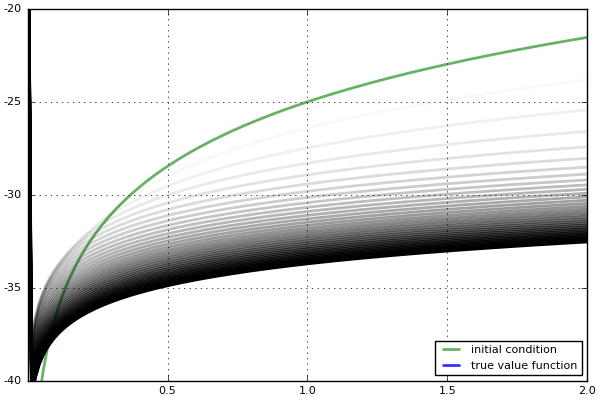

In [52]:
main()